***

# パート2: チャレンジ -  LiH分子に対するVQE


このパートでは、PySCFドライバーでSTG-3G基底を用いて、LiH分子をシミュレートします。

</div>
    
<div class="alert alert-block alert-success">
 
<b>目標</b> 
    
すべてのパラメーターを実験して、ベストな試行状態(ansatz)を見つけてください。好きなだけ創造力を発揮してください！

すべての質問において、パート1と同じように`ansatz`オブジェクトを与えてください。最終スコアは、パート2の結果のみで判定されます。
    
</div>

今回はシステムが大きくなったことに注意してください。このシステムに対して量子ビットが何個必要になるか、スピン軌道の数を得ることによって計算します。

   

### 問題サイズの削減

シミュレーション実行時に量子ビット数を減らしたいかもしれません。
- 化学に大きく貢献していないコア電子を凍結し、価電子のみを考慮することができます。Qiskitには、すでにこの機能が実装されています。よって、`qiskit_nature.transformers` において様々なtransformersを調べて、「フローズンコア近似」を実現するものを探してください。
- 2量子ビットを削減するために、`two_qubit_reduction=True`とともに`ParityMapper`を使うことができます。
- ハミルトニアンの対称性を調べることによって量子ビットの数を削減できる可能性があります。Qiskitの`Z2Symmetries`を使う方法を探してみてください。

### 独自の試行状態(ansatz)

[Grimsley *et al.*,2018](https://arxiv.org/abs/1812.11173v2), [H. L. Tang *et al.*,2019](https://arxiv.org/abs/1911.10205), [Rattew *et al.*,2019](https://arxiv.org/abs/1910.09694), [Tang *et al.*,2019](https://arxiv.org/abs/1911.10205)に提案されているアイディアを使ってみたいかもしれません。ベストな試行回路の生成する機械学習アルゴリズムも参考になるかもしれません。

### シミュレーションの設定

次に、ハートリー・フォック計算を実行させ、その後は、あなたにお任せします！

<div class="alert alert-block alert-danger">

<b>注意事項</b> 

`driver`、`initial_point`、`initial_state` は与えられたものを使ってください。
それ以外はQiskitに用意されているものを全て自由に使うことができます。    
つまり、以下の初期点(すべてのパラメーターが0.01に設定されています)から始めてください：  
    
`initial_point = [0.01] * len(ansatz.ordered_parameters)`
    または
`initial_point = [0.01] * ansatz.num_parameters`

また、初期状態はHF状態を使わなければいけません：
    
`init_state = HartreeFock(num_spin_orbitals, num_particles, converter)`
    
質問ごとに、`ansatz`オブジェクトを指定します。
化学的な精度$|E_{exact} - E_{VQE}| \leq 0.004 $ Ha$ = 4$ mHa に到達する必要があることを忘れないでください。
</div>

***


#### 1. ドライバー
 

Qiskitに用意されている古典的な化学のコードへのインターフェースをドライバーと呼びます。例えば、`PSI4Driver`, `PyQuanteDriver`, `PySCFDriver`が用意されています。

以下のセルで、ドライバーを実行させ(与えられた基底セットと分子構造においてハートリー・フォック法の計算をして)、量子アルゴリズムに適用する分子に関する必要なすべての情報を取得します。

In [20]:
from qiskit_nature.drivers import PySCFDriver

molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

<div class="alert alert-block alert-danger">
    
<b> 練習問題 1</b> 
    
`qmolecule`の特性を調べて、以下の質問に答えましょう。
    
1. 分子の基本的特性を知る必要があります。与えられた系の電子は合計何個ですか？
2. 分子軌道は何個あります？    
3. スピン軌道は何個あります？  
4. この分子をシミュレートするためにジョルダン・ウィグナー変換では何量子ビット必要ですか？
5. 核反発エネルギーの値はいくつですか？

解答は、このノートブックの最後にあります。
</div>

In [21]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)

#### 2. 電子構造の問題

次に、量子ビット（パウリ・ストリング）に変換する前に、フェルミ演算子のリストを生成する`ElectronicStructureProblem`を作ります。

In [22]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
trans = FreezeCoreTransformer(freeze_core=True)
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[trans])

# 第二量子化演算子を作ります
second_q_ops = problem.second_q_ops()

# ハミルトニアン
main_op = second_q_ops[0]

#### 3. 量子ビットへの変換
シミュレーションで使用するマッピングを定義できます。
別の変換も使うことができますが、シンプルな対応である`JordanWignerMapper`を使います：量子ビットを分子におけるスピン軌道として表現します。

In [23]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.operators.second_quantization.qubit_converter import QubitConverter

# 変換器と量子ビット変換を設定
#mapper_type = 'JordanWignerMapper'
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()


converter = QubitConverter(mapper=mapper, two_qubit_reduction=True,z2symmetry_reduction=[1,1])


# フェルミオン演算子が量子ビット演算子に変換されます
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

<ipython-input-23-9d975b406b98>:16: DeprecationWarning: This QubitConverter is deprecated as of 0.1.0, and will be removed no earlier than 3 months after the release. You should use the qiskit_nature.converters.second_quantization QubitConverter as a direct replacement instead.
  converter = QubitConverter(mapper=mapper, two_qubit_reduction=True,z2symmetry_reduction=[1,1])


#### 4. 初期状態

理論の節で説明したように、化学の問題における良い初期状態はHF状態(つまり$|\Psi_{HF} \rangle = |0101 \rangle$)です。以下のように初期化できます：

In [24]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
q_4: ─────
          
q_5: ─────
          


#### 5. 試行状態(Ansatz)

最も重要な選択の一つが、基底状態を近似するために選ぶ量子回路です。
回路として選択可能な量子回路ライブラリーの例を紹介します。

In [25]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# ansatzを選ぶ
#ansatz_type = "TwoLocal"
#ansatz_type = "PUCCD"
#ansatz_type = "UCCSD"
ansatz_type = "SUCCD"


# q-UCC ansatzのためのパラメーター
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# twolocalのための引数を設定
if ansatz_type == "TwoLocal":
    # 単一量子ビット回転は、すべての量子ビットに独立なパラメーターとして置かれます
    rotation_blocks = ['ry', 'rz']
    # エンタングルさせるゲート
    entanglement_blocks = 'cx'
    # 量子ビットをどのくらいエンタングルさせるか
    entanglement = 'full'
    # 独立なパラメーターを持った回転ブロックとエンタングルメントのブロックの繰り返し回数
    repetitions = 1
    # 最後の回転ブロック層をスキップする
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # 初期状態を加える
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":    
    # 回路の作り方の例    
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister    
    # 変分パラメーターの定義
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # 空の量子回路の作成
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # アダマールゲートを置く
    qc.h(qubit_label)
    # CNOTを置く
    for i in range(n-1):
        qc.cx(i, i+1)
    # 見た目のためのセパレーター
    qc.barrier()
    # 全量子ビットへrz回転
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
#ansatz.draw(output='mpl')
print(ansatz)

global phase: 0
     ┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───────────────┐┌───┐┌───┐┌───┐┌───┐»
q_0: ┤ X ├┤ SDG ├┤ H ├┤ X ├┤ X ├┤ X ├┤ X ├┤ RZ(0.25*t[0]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
     ├───┤└─────┘└───┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└───────────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘»
q_1: ┤ X ├──────────────■────┼────┼────┼─────────────────────┼────┼────┼────■──»
     ├───┤                   │    │    │                     │    │    │  ┌───┐»
q_2: ┤ H ├───────────────────■────┼────┼─────────────────────┼────┼────■──┤ H ├»
     └───┘                        │    │                     │    │       └───┘»
q_3: ─────────────────────────────■────┼─────────────────────┼────■────────────»
                                       │                     │                 »
q_4: ──────────────────────────────────┼─────────────────────┼─────────────────»
                                       │                     │                 »
q_5: ──────────────────────────────────■─────────────────────■─────────────────»
            

#### 6. バックエンド

アルゴリズムを実行するシミュレーターまたはデバイスを特定するところです。
このチャレンジでは`statevector_simulator`を使います。



In [26]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. オプティマイザー

オプティマイザーは、試行回路のパラメーターの変化を導き、QPUで実行される測定の数が定義されるエネルギーの収束の評価のためにとても重要です。
賢い選択をすることで、必要となるエネルギー評価の回数を劇的に激減できるでしょう。

In [27]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
#optimizer_type = 'COBYLA'
#optimizer_type = 'L_BFGS_B' #bad
#optimizer_type = 'SPSA'
optimizer_type = 'SLSQP'

# 各オプティマイザーのパラメーターを調整したいかもしれませんが
# ここではデフォルト値を使います
if optimizer_type == 'COBYLA':
    #optimizer = COBYLA(maxiter=1000)
    optimizer = COBYLA(maxiter=2000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=1000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=1000)

#### 8. 厳密固有値ソルバー

学習目的のために、問題をハミルトニアン行列の厳密な対角化によって解くことで、VQEがどこを目指しているかを知ることができます。
もちろん、この行列の次元は分子軌道の数が増えるとともに指数関数的に増大するので、より大きな分子に対してこの方法を試すと、とても時間がかかることを確認できるでしょう。とても大きなシステムにおいては、その波動関数を保持するためのメモリーが足りなくなるでしょう。

In [28]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
#print(result_exact)

Exact electronic energy -1.089782396348742


#### 9. VQEと試行状態のための初期パラメーター
これで、VQEクラスをインポートし、アルゴリズムを実行できます。

In [29]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# リストのデータを出力して保存します
def callback(eval_count, parameters, mean, std):
    # 出力時に同じ行を上書きしてください
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# ansatzの初期パラメーターを設定します
# すべての参加者が似たような初期ポイントから始められるように
# 固定の小さい変位を選びます
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 25,
    'eigenstate': array([ 9.29173020e-18+3.10762068e-17j,  1.32519862e-17+8.72863541e-17j,
        3.77656738e-16-3.05130412e-16j,  9.91485143e-01-1.63612103e-16j,
       -5.26370406e-17-2.84230561e-17j, -2.51877846e-17-2.44505816e-17j,
       -1.80686608e-02+1.44836268e-17j, -4.78590687e-16-3.62630090e-16j,
        1.95879506e-17+4.88100619e-18j, -8.02728890e-18-2.12825053e-17j,
        5.83420507e-17-2.53872900e-17j,  1.33251789e-17-9.35711467e-17j,
       -6.23452977e-17+3.26621145e-17j,  1.39799188e-17-1.25084548e-18j,
       -2.83680743e-02-3.56108361e-17j,  1.32825248e-16-3.51246380e-17j,
       -2.21769486e-17-4.10125677e-17j,  1.04083409e-17+8.47460450e-18j,
        2.48471525e-17-1.17820766e-16j, -1.20353518e-16+1.48474751e-16j,
        5.08003396e-17-9.98742636e-18j,  5.77900722e-17-4.92384158e-17j,
       -1.00060207e-16-4.60242723e-17j,  2.65650496e-17-1.01562795e-16j,
       -4.72090256e-17-2.78533259e-17

#### 9. スコアリング関数

あなたが選択した試行状態/オプティマイザーで、VQEシミュレーションがどれだけ良くできたかを判定する必要があります。
そのために、以下のスコアリング関数を導入します：


$$ score = N_{CNOT}$$


ここで、$N_{CNOT}$はCNOTの数です。
しかし、我々は、化学的精度$\delta E_{chem} = 0.004$ Ha $= 4$ mHaに到達する必要があります。この値は、問題によっては到達が難しい場合があります。
最も少ないCNOTの数でこの精度に到達した人がこのチャレンジの勝者です。スコアの値が小さい方が良いスコアです！

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-30-27ed33383a47>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ansatz_type is "TwoLocal":


,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3.0,0.000008,True,18
1,COBYLA,TwoLocal,12,72,"['ry', 'rz']",cx,full,3.0,220.074898,False,198
2,COBYLA,TwoLocal,12,72,"['ry', 'rz']",cx,full,3.0,219.975110,False,198
3,COBYLA,TwoLocal,12,72,"['ry', 'rz']",cx,full,3.0,219.975110,False,198
4,COBYLA,PUCCD,12,8,NaN,NaN,NaN,NaN,4.148771,False,896
...,...,...,...,...,...,...,...,...,...,...,...
75,NELDER_MEAD,PUCCD,6,4,NaN,NaN,NaN,NaN,4.048289,False,254
76,NELDER_MEAD,PUCCD,6,4,NaN,NaN,NaN,NaN,4.048289,False,254
77,SLSQP,PUCCD,6,4,NaN,NaN,NaN,NaN,4.048436,False,254
78,SLSQP,SUCCD,6,5,NaN,NaN,NaN,NaN,2.198021,True,334


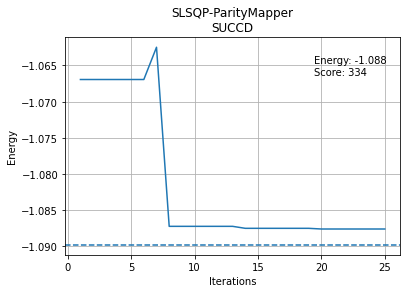

In [30]:
# ディクショナリーに結果を保存します
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# 作った回路をCNOTとUゲートにトランスパイルするUnroller
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuract_thres = 4.0 # mHaの単位
energy = result.optimal_value

if ansatz_type is "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# 結果をプロットします
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# データを表示して保存します
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

In [18]:
# 以下のコードで答えを確認してください。
from qc_grader import grade_ex5
freeze_core = True # 核電子を凍結した場合はTrueにします。
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 334.
Feel free to submit your answer.



In [46]:
# 答えを提出します。何度でも再提出できます。
from qc_grader import submit_ex5
freeze_core = True#False # 核電子を凍結した場合はTrueにします。
submit_ex5(ansatz,qubit_op,result,freeze_core)

Submitting your answer for ex5. Please wait...
Success 🎉! Your answer has been submitted.


# パート1の質問の解答

## Additional information

**Created by:** Igor Sokolov, Junye Huang, Rahul Pratap Singh

**Version:** 1.0.0